In [ ]:
import json                     # module pour load le file
import re                       # module pour retourner les hasthtags
from textblob import TextBlob   # module pour analyser le sentiment du tweet
import pandas as pd             # module pour visualiser et comparer les tweets
import matplotlib.pyplot as plt

# Data utilisé pour la création des dictionnaires pour faciliter l'analyse de diagramme,...
file = open("sample2.json","r")
data =json.load(file)
file.close()

# Data utilisé pour analyser visuellement les différentes caractéristiques d'un tweet
data2 = pd.read_json("sample2.json")
df_data = pd.DataFrame(data2)

In [ ]:
class Tweet :
    def __init__(self,id_tweet,location_tweet,creation_tweet,retweet_count,tweet_language,tweet_text) :
        self.id = id_tweet
        self.location = location_tweet
        self.created = creation_tweet
        self.retweet = retweet_count
        self.language = tweet_language
        self.text = tweet_text
    
    def __str__(self):
        return f"Tweet id : {self.id}\nAuthor Location : {self.location} \nTweet Creation : {self.created} \nNumber of Retweets : {self.retweet} \nTweet Language : {self.language} \nTweet Text : {self.text}"
    
    def get_author(self):
        id_tweet = self.id
        return id_tweet
    
    def get_text(self):
        return f"The text of the tweet : {self.text}"
    
    def get_hashtags(self):
        return re.findall(r"#(\w+)", self.text)

    def get_mention(self):
        return re.findall(r"@(\w+)", self.text)
    
    def get_sentiment(self):
        text = TextBlob(self.text)
        text_polarity = text.sentiment.polarity
        if text_polarity > 0 :
            return "Positive"
        elif text_polarity < 0 :
            return "Negative"
        else :
            return "Neutral" 


#instance/ objets de la class
tweets = [Tweet(tweet["id"],tweet["AuthorLocation"],tweet["CreatedAt"],tweet["RetweetCount"],tweet["TweetLanguage"],tweet["TweetText"]) for tweet in data]

In [ ]:
#########################################################################################################################
##########################################  AVEC LES DICTIONNAIRES   ####################################################
#########################################################################################################################

# Pour Top K Hashtags -> 2 fonctions

# La première : all_hashtag() retourne tout les hashtags du fichier json dans une liste
def all_hashtag():
    l = []                                         # on intialise la liste qui va être retournée à l'éxécution de la fonction
    for tweet in tweets:                           # on parcours tout les tweets (un par un)
        if tweet.get_hashtags()== [] :             # on vérifie avec l'atribut de l'instance si la valeur retourner est  "[]" <- pas de valeur ; dans ce cas là on passe au tweet suivant
            continue
        else :
            temp = tweet.get_hashtags()            # on affecte a temp (variable temporaire) la liste des hashtags de chaque tweet
            for hashtag in temp :                  # on accède à chaque hashtag présent dans temp
                l.append(hashtag)                  # on l'affecte à la liste finale qu'on va retourner
                
    return l
   
# La deuxième : top_hashtag(k) retourne le top k (index) hashtag utilisé dans la database
def top_hashtag(k):
    hashtags = all_hashtag()                       # utilisation de la fonction all_hashtag() pour récupérer la liste complète des hashtag
    hashtag_count = {}                             # on initialise un dictionnaire vide pour compter chaque occurence de chaque hashtag
    for hashtag in hashtags :                      # ici on prend chaque hashtag un par un, ici nommé "e" (pour élément)
        if hashtag in hashtag_count :              # on vérifie si "hashtag" est dans le dictionnaire qui compte les occurences
            hashtag_count[hashtag] += 1            # dans ce cas là on incrémente sa valeur de 1
        else :
            hashtag_count[hashtag] = 1             # dans le cas contraire, on initialise la clé "hashtag" à une valeur initiale de 1 

    hashtag_count = dict(sorted(hashtag_count.items(),key = lambda x : x[1], reverse=True)) # on tri le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(hashtag_count.items())[:k]        # on converti le dictionnaire en une liste pour pouvoir effectué un slicing (afin d'obtenir les top k éléments) 
    top_k_hashtag = dict(temp)                    # on reconverti en dictionnaire afin de pouvoir manipuler les clés et valeurs facilement et dans un odre précis
    
    # Diagramme avec plt
    x_hashtag = list(top_k_hashtag.keys())        # on affecte à la variable x_hashtag les clés du dictionnaire (les hashtags (str))
    y_occurence = list(top_k_hashtag.values())    # on affecte à la variable y_occurence les valeurs des clés du dictionnaire (les occurences)

    plt.bar(x_hashtag,y_occurence)                # on créer le diagramme en bar avec en x -> x_hashtag et en y -> y_occurence
    plt.xlabel("Hashtag")                         # "Hashtag" comme titre de l'axe des x
    plt.ylabel("Occurence")                       # "Occurence" comme titre de l'axe des y

    plt.xticks(fontsize=6)                        # on précise la taille du texte pour les valeurs en x (les hashtags)
    plt.show()                                    # affichage du diagramme

    return top_k_hashtag                          # on retourne en même temps le dictionnaire trié en ordre croissant des top k hashtags

#########################################################################################################################

# Pour Top K Users -> 2 fonctions 

# La première : all_users() qui retourne tout les utilisateurs présent dans le fichier json dans une liste
def all_users():
    l = []                                       # on intialise la liste qui va être retournée à l'éxécution de la fonction
    for tweet in tweets:                         # on parcours tout les tweets (un par un)
        user = tweet.get_author()                # on extrait l'auteur grâce à la méthode .get_author() qu'on place dans la variable user
        l.append(user)                           # on ajoute à la liste l'utilisateur/id du tweet
                
    return l

# La deuxième : top_users(k) qui retourne le top k (index) d'utilisateurs/id présent dans la database
def top_users(k):
    users = all_users()                          # utilisation de la fonction all_users() pour récupérer la liste complète des utilisateurs
    user_ntweet = {}                             # on initialise un dictionnaire vide pour compter chaque occurence de chaque id
    for user in users :                          # ici on prend chaque id un par un, ici nommé "user"
        if user in user_ntweet :                 # on vérifie si l'id est déjà dans le dictionnaire
            user_ntweet[user] += 1               # si c'est le ce cas, on incrémente sa valeur de 1 
        else :
            user_ntweet[user] = 1                # sinon on crée une clé pour l'id correspondant et on initie sa valeur à 1 

    user_ntweet = dict(sorted(user_ntweet.items(),key = lambda x : x[1], reverse=True)) # on tri le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(user_ntweet.items())[:k]         # on converti le dictionnaire en une liste pour pouvoir effectué un slicing (afin d'obtenir les top k éléments)
    top_k_users = dict(temp)                     # on reconverti en dictionnaire afin de pouvoir manipuler les clés et valeurs facilement et dans un odre précis

    x_user = list(top_k_users.keys())            # on affecte à la variable x_user les clés du dictionnaire (les id (str))
    y_occurence = list(top_k_users.values())     # on affecte à la variable y_occurence les valeurs du dictionnaire (les occurences)

    plt.bar(x_user,y_occurence)                  # on créer le diagramme en bar avec en x -> x_hashtag et en y -> y_occurence
    plt.xlabel("User")                           # "User" comme titre de l'axe des x
    plt.ylabel("Occurence")                      # "Occurence" comme titre de l'axe des y

    plt.xticks(fontsize=6)                       # on précise la taille du texte pour les valeurs en x (les id)
    plt.show()                                   # affichage du diagramme


    return top_k_users                           # on retourne en même temps le dictionnaire trié en ordre croissant des top k users


#########################################################################################################################

# Pour the top K mentions -> 2 fonctions 

# La première : all_mentions() qui retourne toutes les mentions de la database
def all_mentions():
    l = []                                        # on initialise la liste qui va être utilisée pour retourner les mentions à l'éxécution de la fonction
    for tweet in tweets:
        if tweet.get_mention()== [] :             # on vérifie avec l'atribut de l'instance si la valeur retourner est  "[]" <- pas de valeur ; dans ce cas là on passe au tweet suivant
            continue
        else :
            mentions = tweet.get_mention()        # on place les mentions obtenues du tweet dans la variable temporaire mentions (qui va correspondre à une liste) 
            for mention in mentions :             # on parcours chaque élément de la liste (ils peuvent être dans une liste de liste par exemple :[[mention],mention2,...])
                l.append(mention)                 # et on l'ajoute à notre liste finale
                
    return l

def top_mention(k):
    mentions = all_mentions()                       # utilisation de la fonction all_mentions() pour récupérer la liste complète des mentions
    mention_ntweet = {}                             # on initialise un dictionnaire vide pour compter chaque occurence de chaque mention
    for mention in mentions :                       # ici on prend chaque mention, une par une
        if mention in mention_ntweet :              # on vérifie si la mention est présente dans le dictionnaire
            mention_ntweet[mention] += 1            # dans ce cas là on incrémente la valeur corresponde à la mention (la clé)
        else :
            mention_ntweet[mention] = 1             # dans le cas contraire on initie la clé correspondante à la mention à 1

    mention_ntweet = dict(sorted(mention_ntweet.items(),key = lambda x : x[1], reverse=True)) # on tri le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(mention_ntweet.items())[:k]         # on converti le dictionnaire en une liste pour pouvoir effectué un slicing (afin d'obtenir les top k éléments)
    top_k_mentions = dict(temp)                     # on reconverti la liste en dictionnaire trié en ordre croissant des top k mentions

    x_mention = list(top_k_mentions.keys())         # on affecte à la variable x_mention les clés du dictionnaire (les mentions (str))
    y_occurence = list(top_k_mentions.values())     # on affecte à la variable y_occurence les valeurs du dictionnaire (les occurences)

    plt.bar(x_mention,y_occurence)                  # on créer le diagramme en bar avec en x -> x_mention et en y -> y_occurence
    plt.xlabel("Mention",)                          # on créer le diagramme en bar avec en x -> x_mention
    plt.ylabel("Occurence")                         # on créer le diagramme en bar avec en y -> y_occurence

    plt.xticks(fontsize=7)                          # on précise la taille du texte pour les valeurs en x (les mentions)
    plt.show()                                      # affichage du diagramme

    return top_k_mentions                           # on retourne en même temps le dictionnaire trié en ordre croissant des top k mentions

#########################################################################################################################

def top_topics():
    pass


#########################################################################################################################
##########################################  AVEC LES DATAFRAMES   #######################################################
#########################################################################################################################


def all_tweet_mention(mention):                                                               # fonction qui retourne l'ensemble des tweets mentionnant un utilisateur spécifique dans un dataframe
    return df_data[df_data["TweetText"].str.contains(f"@{mention}",regex=False)]              # on tri les lignes de la database pour extraire seulement celle qui contiennent @mention dans la colonne 

def all_tweet_hashtag(hashtag):                                                               # fonction qui retourne l'ensemble des tweets faisant référence à un hashtag spécifique
    return df_data[df_data["TweetText"].str.contains(f"#{hashtag}",regex=False)]              # on tri les lignes de la database pour extraire seulement celle qui contiennent #hashtag dans la colonne de TweetText

def user_specified_hashtag(hashtag):                                                          # fonction qui retourne les id de chaque utilisateur mentionnant un hashtag spécifique
    return df_data[df_data["TweetText"].str.contains(f"#{hashtag}",regex=True)].get("id")     # on tri les lignes de la database pour extraire  les #hashtag présent dans la colonne TweetText et on extrait seulement les id

def user_mentionned(user):                                                                    # fonction qui retourne les utilisateurs mentionnés par un utilisateur spécifique
    text = str(df_data[df_data["id"]==user].get("TweetText"))                                 # on attribue à la variable text le texte du tweet qui correspond à l'utilisiateur spécifique
    return re.findall(r"@(\w+)", text)                                                        # on nettoie le text en extrayant les mentions avec le r"@(\w+)"



In [55]:
user_mentionned(1417013867725656064)

['RajukSrivastav1']

In [53]:
all_tweet_hashtag("MachineLearning")

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
3,1415291968700264448,Internet,2021-07-14T12:47:54Z,20,en,RT @HarbRimah: Making AI Sing https://t.co/FJo...
51,1415443187666141184,,2021-07-14T22:48:48Z,4,en,RT @Udemy_Coupons1: Artificial Intelligence (A...
52,1415443205995249664,Everywhere,2021-07-14T22:48:52Z,4,en,RT @Udemy_Coupons1: Artificial Intelligence (A...
121,1415654597964615680,,2021-07-15T12:48:52Z,7,en,RT @digitalkecom: The branches of Artificial I...
154,1415775469161652224,Europe,2021-07-15T20:49:10Z,37,en,RT @Paula_Piccard: Decoding crop genetics with...
...,...,...,...,...,...,...
1636,1421182351166558208,United Arab Emirates,2021-07-30T18:54:11Z,14,en,RT @bimedotcom: What is the Difference Between...
1637,1421182439897157632,,2021-07-30T18:54:32Z,14,en,RT @bimedotcom: What is the Difference Between...
1638,1421182364164796416,Switzerland,2021-07-30T18:54:14Z,14,en,RT @bimedotcom: What is the Difference Between...
1675,1421333417006931968,"Kyiv, Ukraine",2021-07-31T04:54:28Z,122,en,RT @Paula_Piccard: Artificial Intelligence len...


In [50]:
all_tweet_mention("nigewillson")

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
20,1415337411350040576,"Kyiv, Ukraine",2021-07-14T15:48:29Z,4,en,RT @nigewillson: Unleashing The Power Of A Div...
94,1415579078950735872,Mysore and BERLIN,2021-07-15T07:48:47Z,1,en,RT @nigewillson: Artificial intelligence will ...
96,1415579123028676608,Mysore and BERLIN,2021-07-15T07:48:57Z,3,en,RT @nigewillson: This Artificial Intelligence ...
459,1416787254278754304,U.K.,2021-07-18T15:49:38Z,9,en,RT @nigewillson: Artificial Intelligence desig...
498,1416983641880735744,"Kyiv, Ukraine",2021-07-19T04:50:01Z,27,en,RT @nigewillson: Artificial Intelligence desig...
699,1417753918558412800,"London, England",2021-07-21T07:50:49Z,2,en,RT @nigewillson: Why business and academia nee...
741,1417889895444619264,"Berlin, Deutschland",2021-07-21T16:51:08Z,2,en,RT @nigewillson: Time for a Robot CEO? With ad...
743,1417889877425807360,,2021-07-21T16:51:04Z,2,en,RT @nigewillson: Time for a Robot CEO? With ad...
758,1417935180426326016,Slovakia,2021-07-21T19:51:05Z,9,en,RT @nigewillson: An Artificial Intelligence an...
794,1418101303188852736,Switzerland,2021-07-22T06:51:12Z,8,en,RT @nigewillson: Future Artificial Intelligenc...


In [ ]:
user_mentionned(1415291886860967936)

In [ ]:
df_data

In [ ]:
top_hashtag(5)

In [ ]:
all_tweet_mention("NEJM")

In [ ]:
# Test for Top k hashtags
all_hashtag()
top_hashtag(3)

In [ ]:
# Test for Top k users
all_users()
top_users(4)

In [ ]:
# Test for Top k mentions
all_mentions()
top_mention(7)

In [ ]:
all_tweet_hashtag("DataScience")

In [ ]:
all_tweet_mention("SpirosMargaris")

In [ ]:
df_data

In [ ]:
all_hashtag()

In [ ]:
user_specified_hashtag("FEATURED")

In [ ]:
user_mentionned(1415291886860967936)

In [ ]:
all_tweet_hashtag("machine")

In [ ]:
str = "My day is shit"


In [33]:
tweets[0].get()

'The text of the tweet : RT @HDataSystems: Artificial Intelligence and Augment Analytics Shaping Financial Sector https://t.co/Mi3BohmgDh \n\n#hdatasystems #Artificia…'

In [60]:
text = "bonjouir comment ca va "
a = TextBlob(text)
print(a.polarity)
if a.polarity > 0 :
    print("Positive")
elif a.polarity < 0 :
    print( "Negative")
else :
    print( "Neutral" )

0.0
Neutral


<BarContainer object of 3 artists>

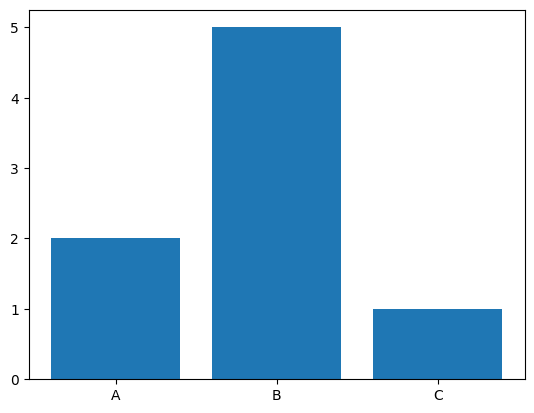

In [41]:
a = ["A","B","C"]
b = [2,5,1]

plt.bar(a,b)